# Setting Parameters

In [1]:
# Params
RANDOM_SEED = 45
BATCH_SIZE = 64

# Loading Packages

In [2]:
# Importing Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import os

# Loading Data

## Prep Data into DataFrame

In [3]:
# download from kaggle
# First check if the dataset is already downloaded
if not os.path.exists('./data/cartoon-faces-googles-cartoon-set.zip'):
    # Download the dataset
    !pip install kaggle
    !kaggle datasets download -d brendanartley/cartoon-faces-googles-cartoon-set -p ./data
else:
    print("Dataset already downloaded")

Dataset already downloaded


In [4]:
# unzip files in python
import zipfile

# get current directory
home_dir = os.getcwd()

# unzip, if not already unzipped
if not os.path.exists(home_dir + '/data/cartoonset100k_jpg'):
    with zipfile.ZipFile(home_dir + '/data/cartoon-faces-googles-cartoon-set.zip', 'r') as zip_ref:
        zip_ref.extractall(home_dir + '/data')
else:
    print("Dataset already unzipped")

Dataset already unzipped


In [5]:
# Put file paths in a DataFrame

# initialize dataframe
data = pd.DataFrame(columns=["path"])

# Initialize directory and translate dict (only use first 10k images)
dir = home_dir +  "/data/cartoonset100k_jpg/0"

for subdir in os.listdir(dir):
    data.loc[len(data)] = [dir + "/" + subdir]

print(f"There are {len(data)} images in the dataset")
data.head()

There are 10000 images in the dataset


,path
0,/home/adam-taback/Desktop/APS360/Project/Final...
1,/home/adam-taback/Desktop/APS360/Project/Final...
2,/home/adam-taback/Desktop/APS360/Project/Final...
3,/home/adam-taback/Desktop/APS360/Project/Final...
4,/home/adam-taback/Desktop/APS360/Project/Final...


## Load into PyTorch

In [6]:
# import packages
from torch.utils.data import Dataset
from PIL import Image

### Define Dataset Class

In [7]:
# Define Dataset
class CartoonDataset(Dataset):
    def __init__(self, X, transform=None):
        self.X = np.asarray(X).ravel()
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        # print(f"Opening image: {img_path}")
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img


    def show_img(self, idx):
        '''Plot image'''
        img = self.__getitem__(idx)
        if img is not None:
            img = img.numpy().transpose((1, 2, 0))
            plt.figure(figsize=(16, 8))
            plt.axis('off')
            plt.imshow(img)
            plt.pause(0.001)

### Define Transforms

In [33]:
# Define Transforms
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(0,1)
])

### Generate Datasets and Plot examples

In [34]:
# Generate DataSets

cartoon_set = CartoonDataset(data["path"],transform=transform)

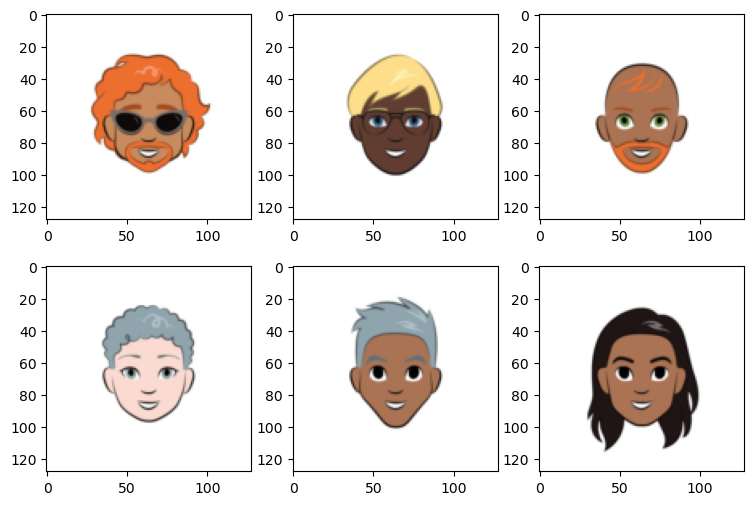

In [35]:
# Plot first 9 images

# define plot
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

# iterate
for i in range(2):
  for j in range(3):
    img = cartoon_set[i*3 + j]
    img = img.numpy().transpose((1, 2, 0))
    axes[i,j].imshow(img)

### Prep Dataloaders

In [36]:
# make dataloader
from torch.utils.data import DataLoader

cartoon_loader = DataLoader(cartoon_set, batch_size=BATCH_SIZE, shuffle=False)

# Baseline Model

# Primary Model

In [37]:
# import packages
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils

In [38]:
device = "cpu"
device

'cpu'

In [39]:
# size of generator feature maps
sizeGF = 128
# size of discriminator feature maps
sizeDF = 128

## Generator

In [40]:
class Generator(nn.Module):
    def __init__(self, n_channels = 3, size_noise = 100):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(size_noise, sizeGF * 8, 4, 1, 0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(sizeGF * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(sizeGF * 8, sizeGF * 4, 4, 2, 1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(sizeGF * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(sizeGF * 4, sizeGF * 2, 4, 2, 1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(sizeGF * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(sizeGF * 2, sizeGF, 4, 2, 1, bias=False),  # 16x16 -> 32x32
            nn.BatchNorm2d(sizeGF),
            nn.ReLU(True),

            nn.ConvTranspose2d(sizeGF, n_channels, 4, 2, 1, bias=False),  # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, input):
        return self.layers(input)

## Discriminator

In [41]:
class Discriminator(nn.Module):
    def __init__(self, n_channels=3):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(n_channels, sizeDF, 4, 2, 1, bias=False),  # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF, sizeDF * 2, 4, 2, 1, bias=False),  # 32x32 -> 16x16
            nn.BatchNorm2d(sizeDF * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF * 2, sizeDF * 4, 4, 2, 1, bias=False),  # 16x16 -> 8x8
            nn.BatchNorm2d(sizeDF * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF * 4, sizeDF * 8, 4, 2, 1, bias=False),  # 8x8 -> 4x4
            nn.BatchNorm2d(sizeDF * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF * 8, sizeDF * 16, 4, 2, 1, bias=False),  # 4x4 -> 2x2
            nn.BatchNorm2d(sizeDF * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(sizeDF * 16, 1, 2, 1, 0, bias=False),  # 2x2 -> 1x1
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        output = output.view(output.size(0), -1)  # Flatten the output
        return output

## VAE

In [42]:
# Define the Encoder
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x64x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x32x32
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x16x16
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)  # Output: 256x8x8
        self.conv5 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)  # Output: 512x4x4
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
    
    def forward(self, x):
        h = torch.relu(self.conv1(x))
        h = torch.relu(self.conv2(h))
        h = torch.relu(self.conv3(h))
        h = torch.relu(self.conv4(h))
        h = torch.relu(self.conv5(h))
        h = h.view(h.size(0), -1)  # Flatten
        h = torch.relu(self.fc1(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Define the Decoder
class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(ConvDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 1024)
        self.fc2 = nn.Linear(1024, 512 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)  # Output: 256x8x8
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # Output: 128x16x16
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # Output: 64x32x32
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # Output: 32x64x64
        self.deconv5 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)  # Output: 3x128x128
    
    def forward(self, z):
        h = torch.relu(self.fc(z))
        h = torch.relu(self.fc2(h))
        h = h.view(h.size(0), 512, 4, 4)
        h = torch.relu(self.deconv1(h))
        h = torch.relu(self.deconv2(h))
        h = torch.relu(self.deconv3(h))
        h = torch.relu(self.deconv4(h))
        x_recon = torch.sigmoid(self.deconv5(h))
        return x_recon

# Define the VAE
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
    
    def sample(self, num_samples, z):
        # Sample points in z and decode them
        samples = self.decoder(z)
        return samples


# Loss function
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

# Plotting Training images, VAE images and GAN images

In [43]:
# Initialize the VAE
latent_dim = 15
vae = ConvVAE(latent_dim).to(device)
vae.load_state_dict(torch.load(home_dir + "/models/cartoon_vae/vae_epoch_35.pth"))

# Initialize the Generator
generator = Generator().to(device)
generator.load_state_dict(torch.load(home_dir + "/models/cartoon_gan/generator_epoch_10.pth"))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


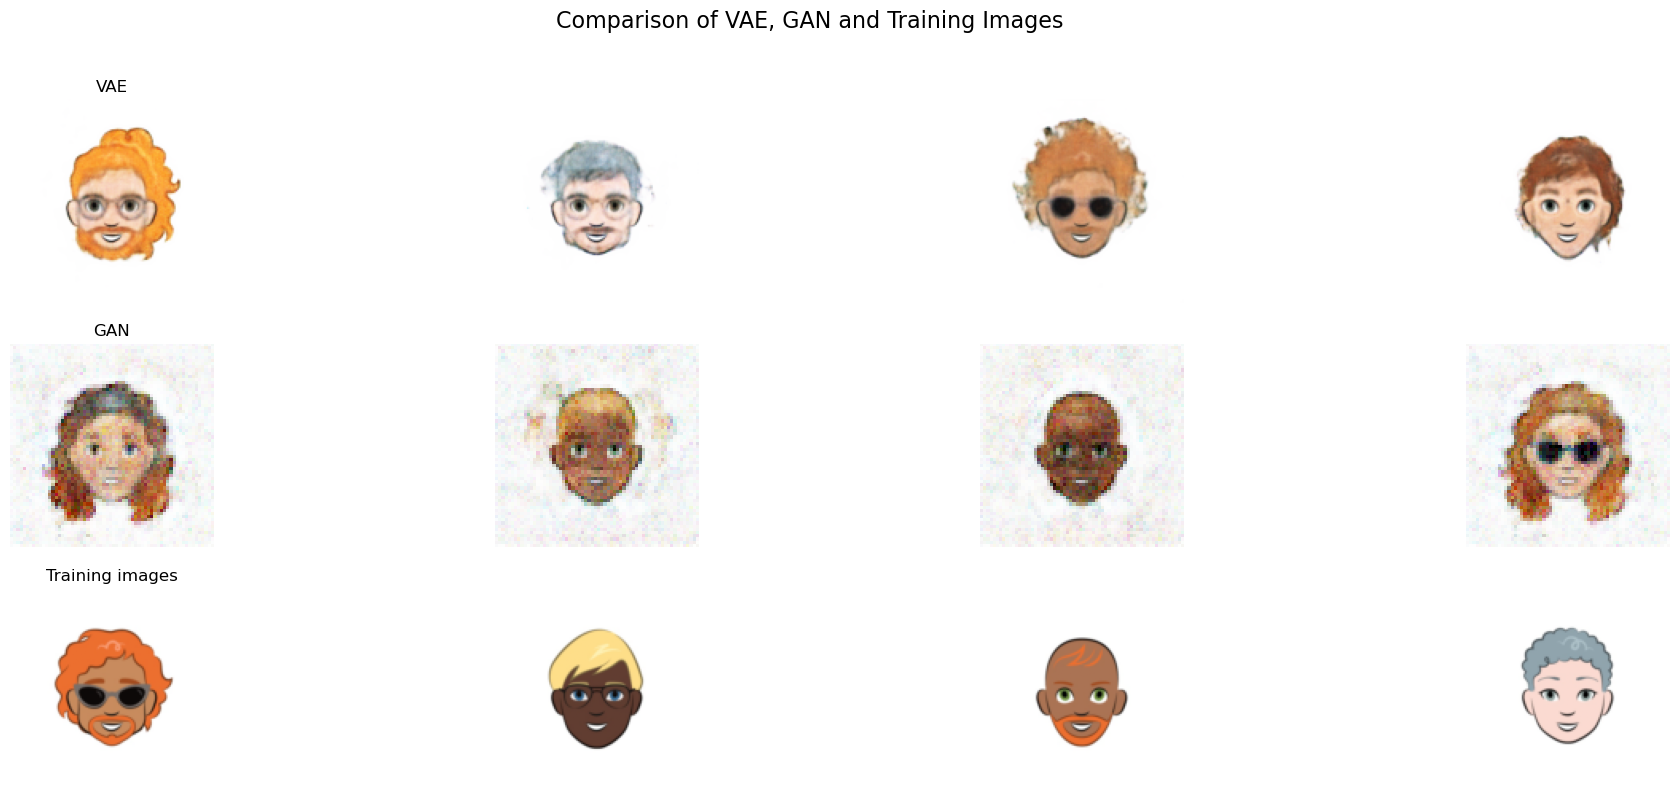

In [51]:
# Plotting all
n_img = 4

fig, axes = plt.subplots(3, n_img, figsize=(6 * n_img, 9))

# VAE
for i in range(n_img):
    noise = torch.randn(1, latent_dim).to(device)
    img = vae.sample(1, noise)
    img = img.squeeze(0).detach().cpu().numpy().transpose((1, 2, 0))
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    
# title row 0 VAE
axes[0, 0].set_title('VAE')
    
# GAN
for i in range(n_img):
    noise = torch.randn(1, 100, 1, 1).to(device)
    img = generator(noise)
    img = img.squeeze(0).detach().cpu().numpy().transpose((1, 2, 0))
    axes[1, i].imshow(img)
    axes[1, i].axis('off')
    
# title row 1 GAN
axes[1, 0].set_title('GAN')
    
# Training images
for i in range(n_img):
    img = cartoon_set[i]
    img = img.numpy().transpose((1, 2, 0))
    axes[2, i].imshow(img)
    axes[2, i].axis('off')
    
# title row 2 Training images
axes[2, 0].set_title('Training images')

# Title
plt.suptitle('Comparison of VAE, GAN and Training Images', fontsize=16)
    
# save the plot
plt.savefig(home_dir + "/all_models.png")
    
plt.show()